In [1]:
import numpy
import torch
import torch.nn as nn
from collections import OrderedDict
import os
import sys
import warnings
from torch.utils.data import DataLoader
import argparse
import time
import copy
import math
import torchvision.utils as vision_utils
import json
import numpy as np
from torch.distributions import bernoulli
from scipy import linalg
import torchvision.datasets as _datasets
import torchvision.transforms as _transforms
import matplotlib.pyplot as plt
import shutil

from data import Binarize, Smooth, load_mnist, get_sampler
from evals import compute_mu_sigma_pretrained_model, calculate_frechet_distance, _calculate_metrics, get_metrics
from losses import get_disciminator_loss, get_generator_loss
from model import DiscriminatorCNN28, GeneratorCNN28, MLP_mnist, pretrained_mnist_model
from trainer import train
from updates import Lookahead, update_avg_gen, update_ema_gen
from utils import save_models, get_plot_func, get_num_params

In [2]:
a = 1

In [3]:
_NOISE_DIM = 8
_H_FILTERS = 2

In [4]:
G = GeneratorCNN28(noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=True)
D = DiscriminatorCNN28(h_filters=_H_FILTERS, spectral_norm=False, img_size=28)

In [5]:
get_num_params(G)

3832

In [6]:
get_num_params(D)

768

Loading trained model from ./drive/My Drive/Data/models/mnist.pth
Iter 0: Mean proba from D(G(z)): 0.4934 +/- 0.0958


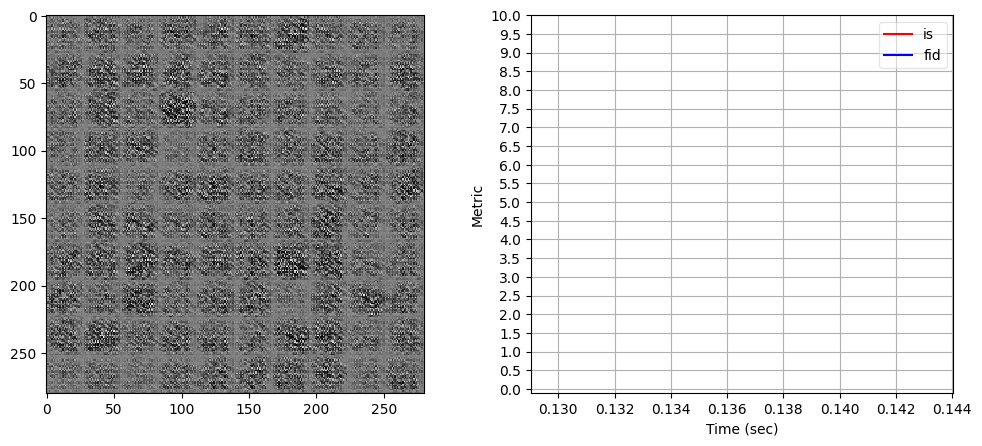

Iter 5000: Mean proba from D(G(z)): 0.5008 +/- 0.0059


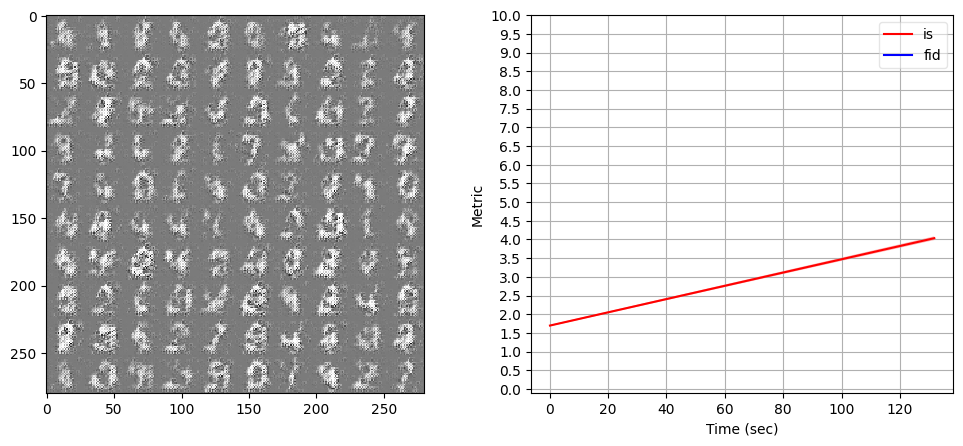

Iter 10000: Mean proba from D(G(z)): 0.4998 +/- 0.0035


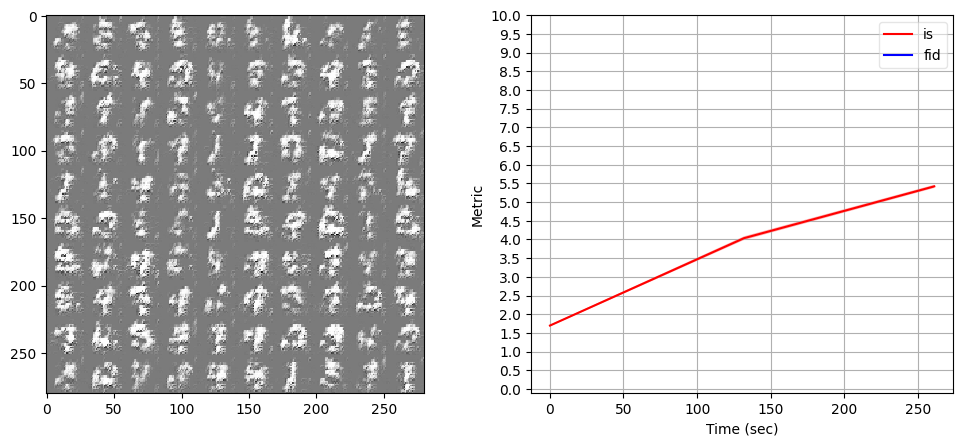

Iter 15000: Mean proba from D(G(z)): 0.4995 +/- 0.0017


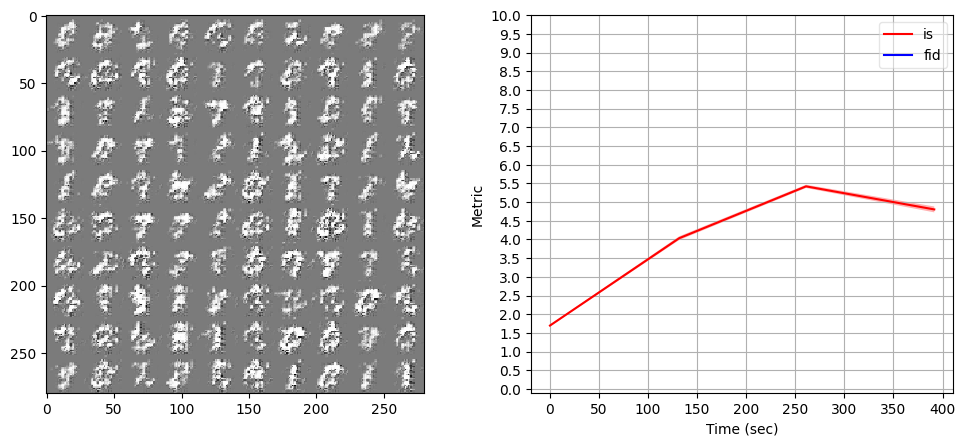

Iter 20000: Mean proba from D(G(z)): 0.4975 +/- 0.0154


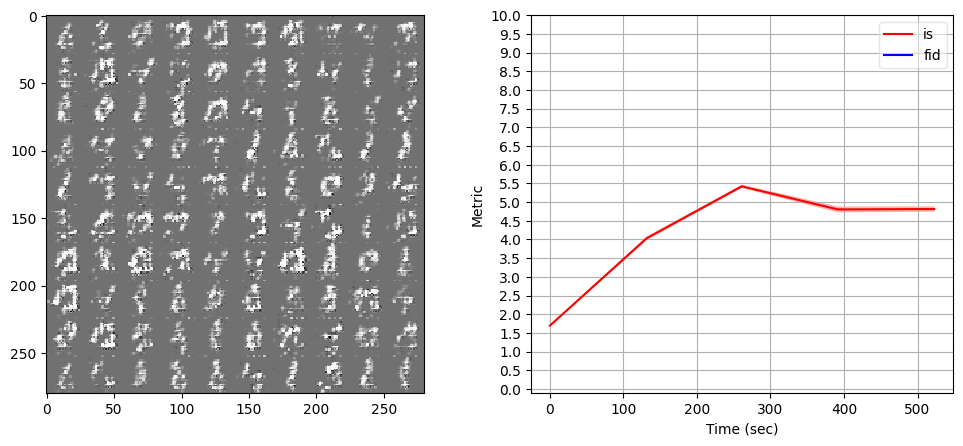

Iter 25000: Mean proba from D(G(z)): 0.4675 +/- 0.0662


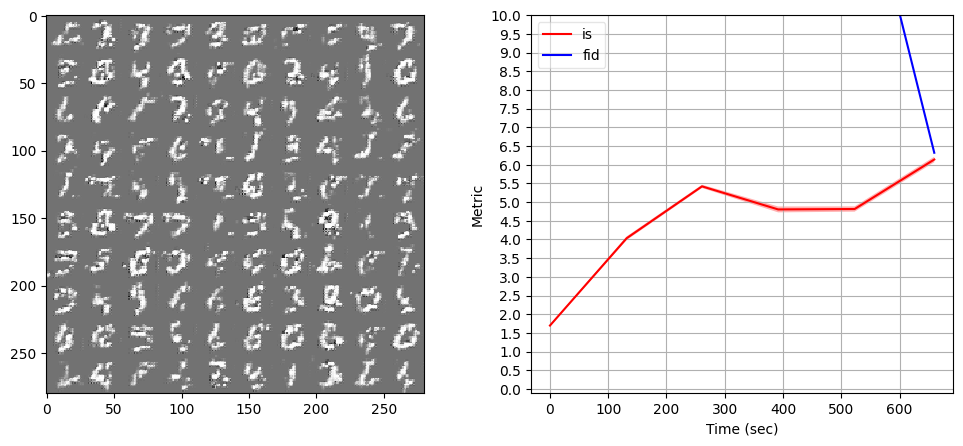

Iter 30000: Mean proba from D(G(z)): 0.4872 +/- 0.0473


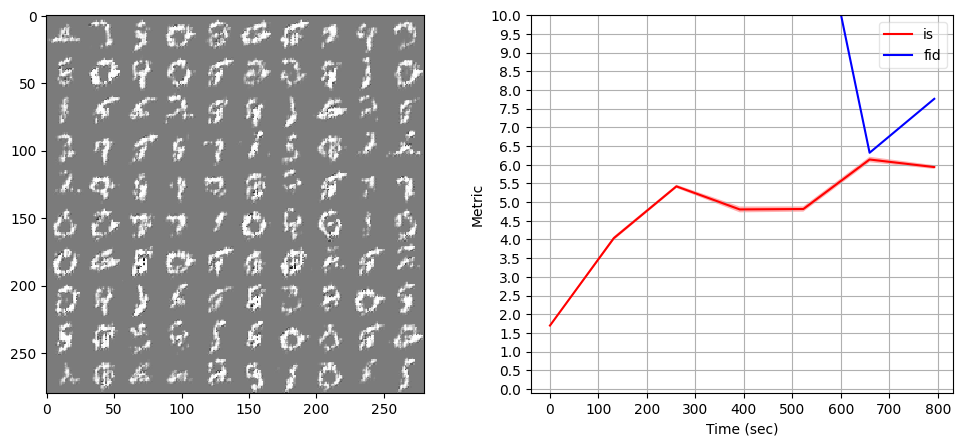

Iter 35000: Mean proba from D(G(z)): 0.5034 +/- 0.0330


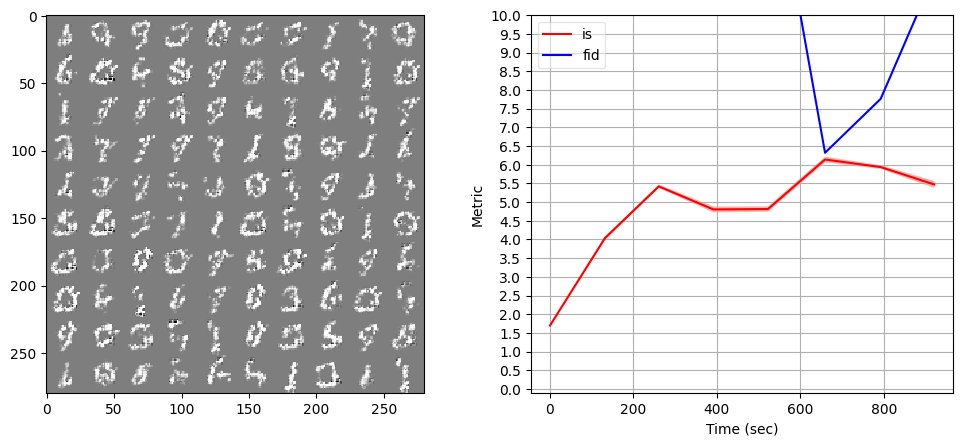

Iter 40000: Mean proba from D(G(z)): 0.4981 +/- 0.0139


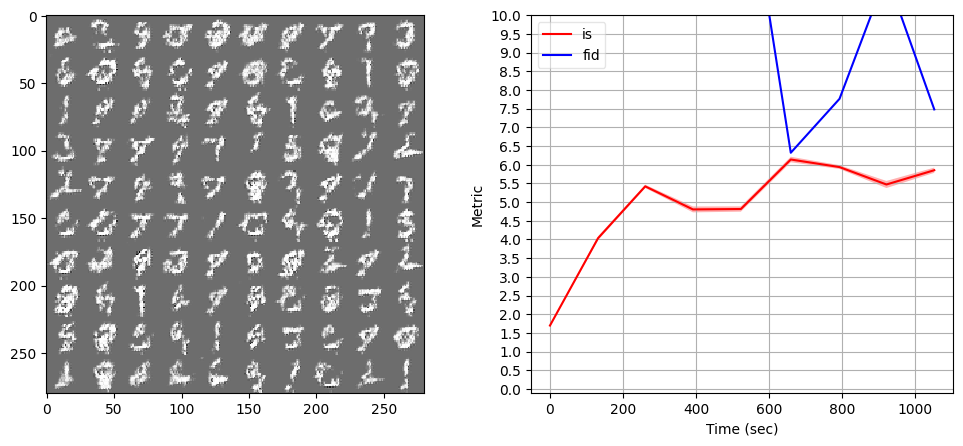

Iter 45000: Mean proba from D(G(z)): 0.5038 +/- 0.0170


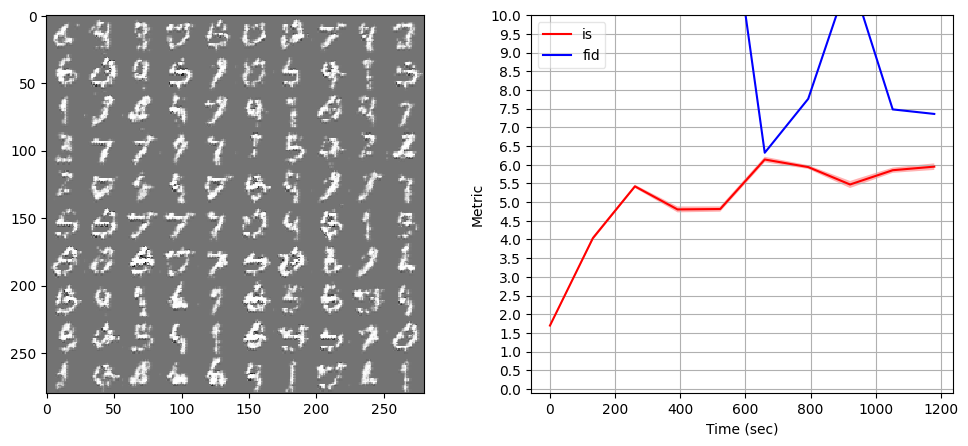

Iter 50000: Mean proba from D(G(z)): 0.4550 +/- 0.0686


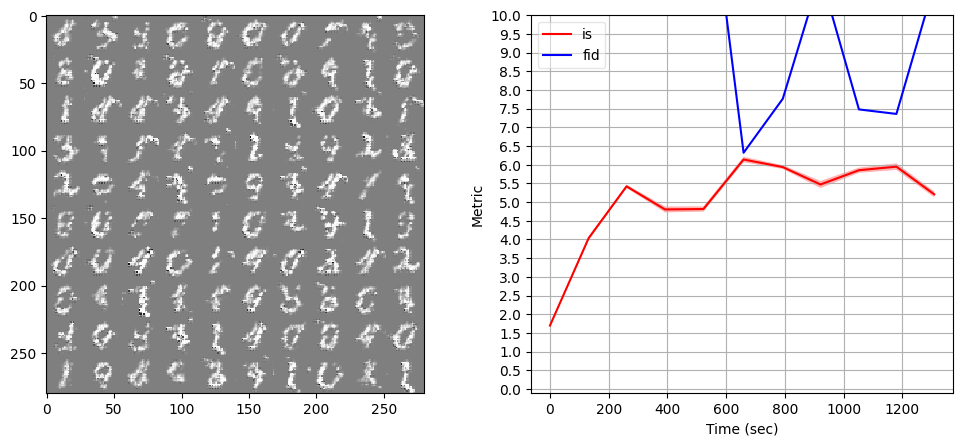

Iter 55000: Mean proba from D(G(z)): 0.4999 +/- 0.1085


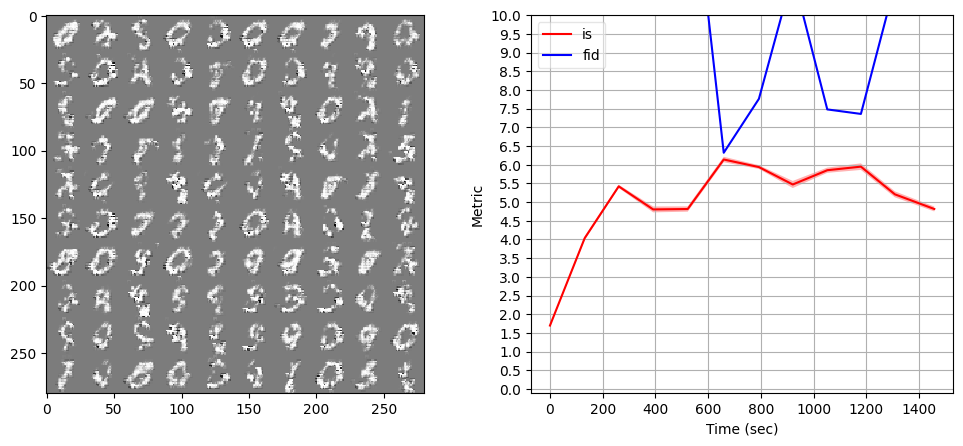

Iter 60000: Mean proba from D(G(z)): 0.4724 +/- 0.0985


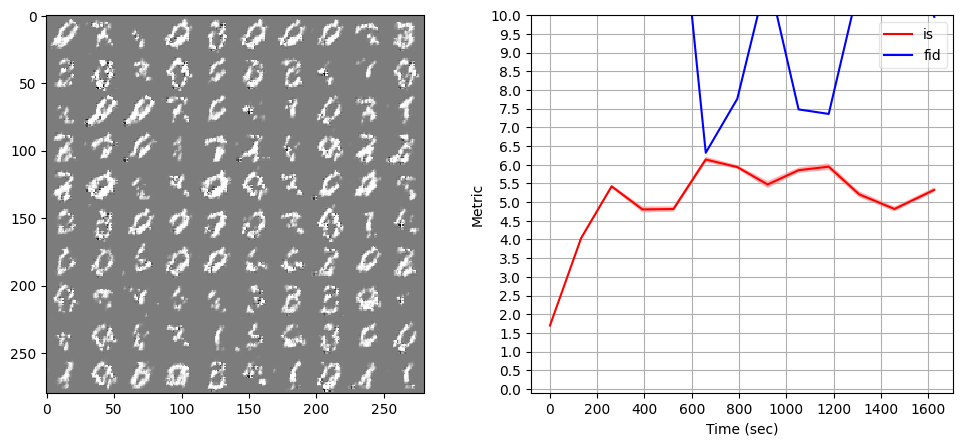

Iter 65000: Mean proba from D(G(z)): 0.4564 +/- 0.0893


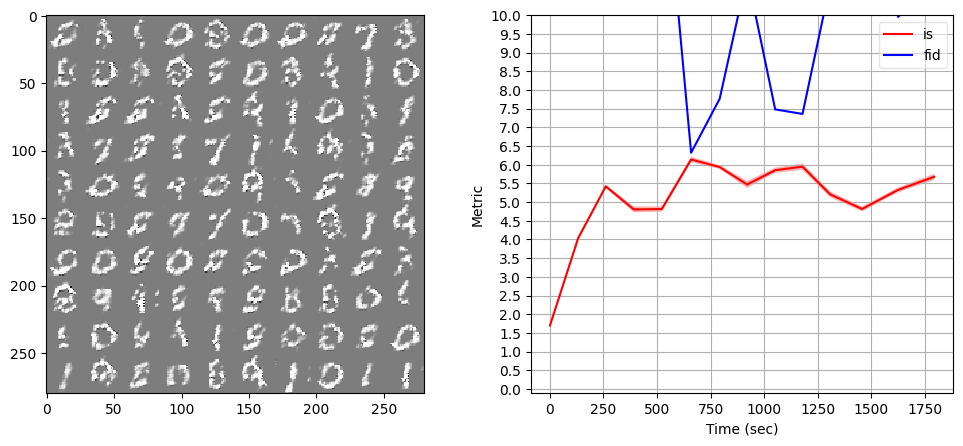

Iter 70000: Mean proba from D(G(z)): 0.4853 +/- 0.0830


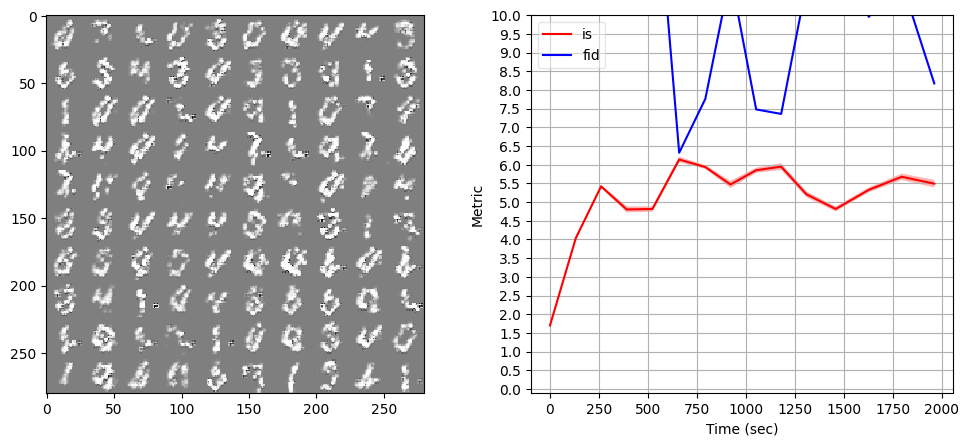

Iter 75000: Mean proba from D(G(z)): 0.4106 +/- 0.1383


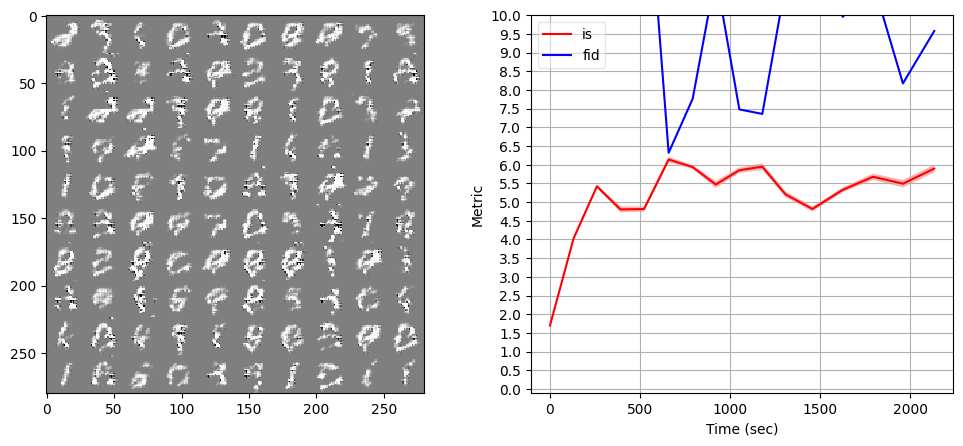

Iter 80000: Mean proba from D(G(z)): 0.3759 +/- 0.0827


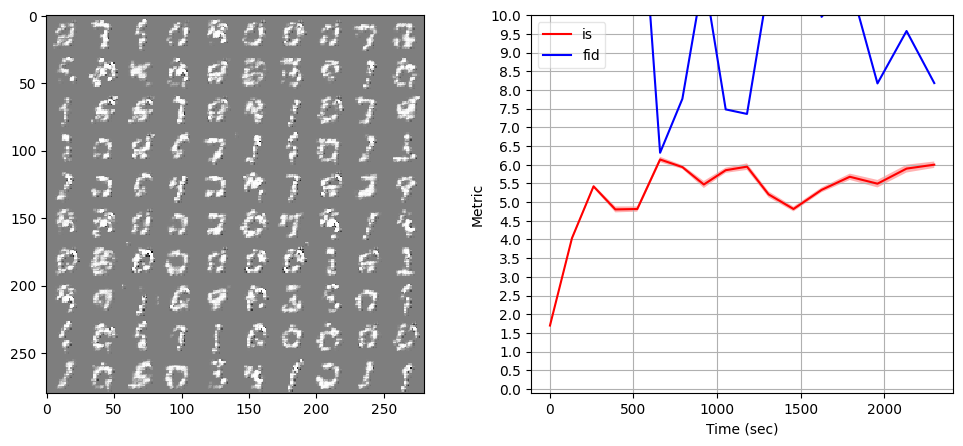

Iter 85000: Mean proba from D(G(z)): 0.5211 +/- 0.0936


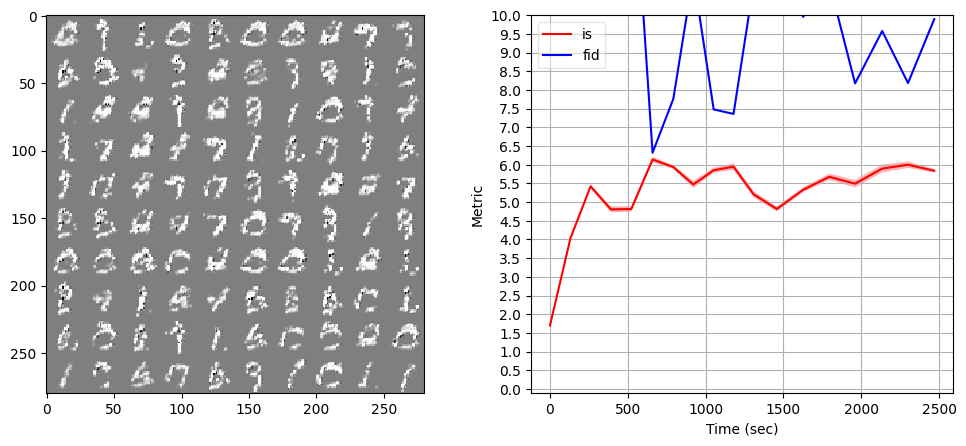

Iter 90000: Mean proba from D(G(z)): 0.5052 +/- 0.0789


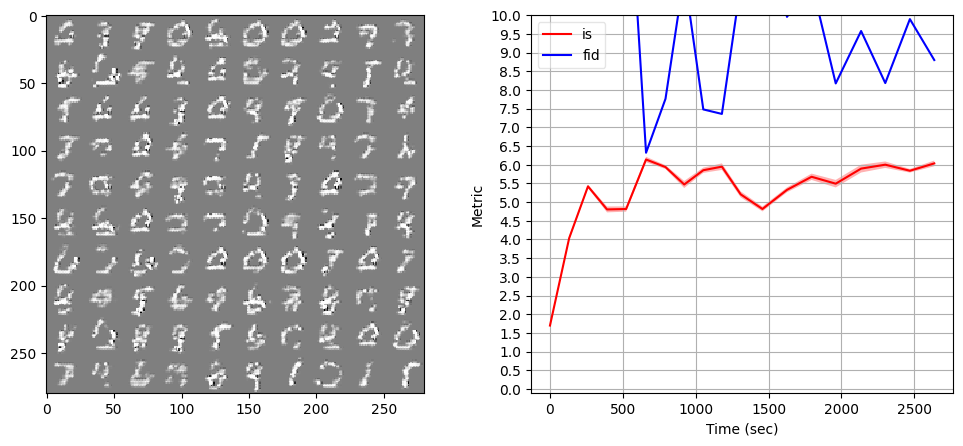

Iter 95000: Mean proba from D(G(z)): 0.5011 +/- 0.0671


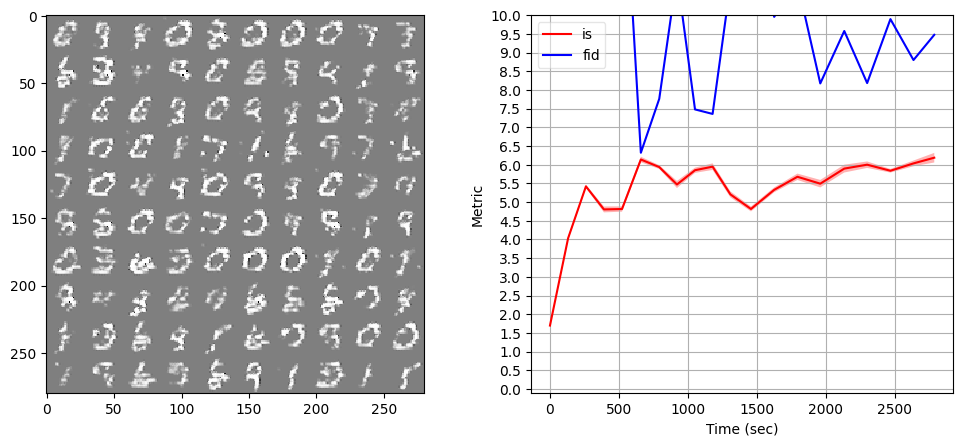

Iter 99999: Mean proba from D(G(z)): 0.4381 +/- 0.0794


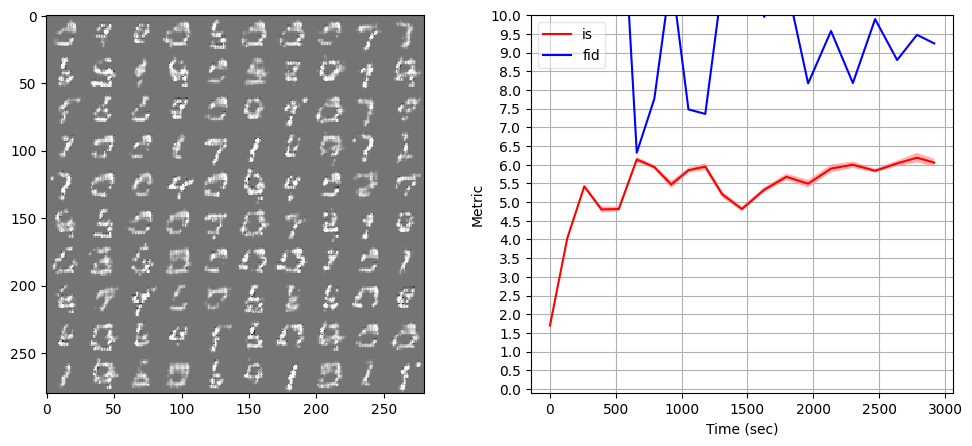

In [7]:
args = dict(iterations = 100000,
            batch_size = 128,
            lrD = 0.001,
            lrG = 0.001,
            beta1 = 0.05,
            extragrad = False,
            eval_every = 5000,
            lookahead = False,
            eval_avg = False,
            lookahead_k = 1000,
            n_workers = 5,
            device = 'cuda',
            grad_max_norm = None)


for k in range(1,1+1):
  exp_key = f"iter{args['iterations']}_bs{args['batch_size']}_lrD{args['lrD']}" + \
            f"_lrG{args['lrG']}_beta1{args['beta1']}_lookahead{args['lookahead']}" + \
            f"_lak{args['lookahead_k']}" + \
            f"_extragrad{args['extragrad']}_ee{args['eval_every']}"
  out_dir = f"/home/mila/t/tianyu.zhang/GAN_LOLA/drive/My Drive/results/final/{exp_key}/{k}/"

  shutil.rmtree(out_dir, ignore_errors=True)
  if not os.path.exists(out_dir):
    os.makedirs(out_dir)

  with open(os.path.join(out_dir, 'args.json'), 'w') as fs:
    json.dump(args, fs)

  dataset = load_mnist(_data_root='datasets', binarized=False)

  plot_func = get_plot_func(out_dir=out_dir, 
                            img_size=dataset[0][0].size(),
                            num_samples_eval=10000)

  G = GeneratorCNN28(noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=True)
  D = DiscriminatorCNN28(h_filters=_H_FILTERS, spectral_norm=False, img_size=28)

  train(G, D, dataset, 
        iterations=args['iterations'], 
        batch_size=args['batch_size'], 
        lookahead=args['lookahead'],
        lookahead_k=args['lookahead_k'],
        eval_avg=args['eval_avg'],
        lrD=args['lrD'], 
        lrG=args['lrG'], 
        beta1=args['beta1'], 
        extragrad=args['extragrad'],
        eval_every=args['eval_every'], 
        n_workers=args['n_workers'], 
        device=torch.device(args['device']), 
        grad_max_norm=args['grad_max_norm'], 
        plot_func=plot_func,
        out_dir=out_dir)

In [1]:
import torch
import numpy as np
from torch.nn import Module
import torch.nn.functional as F

class Net(Module):
    def __init__(self, h, w):
        super(Net, self).__init__()
        self.c1 = torch.nn.Conv2d(1, 32, 3, 1, 1)
        self.f2 = torch.nn.Linear(32 * h * w, 5)

    def forward(self, x):
        x = self.c1(x)
        x = x.view(x.size(0), -1)
        x = self.f2(x)
        return x

def haha(a, b, c, d):
    p = [a.view(32, 1, 3, 3), b, c.view(5, 32 * 12 * 12), d]
    x = torch.randn(size=[8, 1, 12, 12], dtype=torch.float32)
    y = torch.randint(0, 5, [8])
    x = F.conv2d(x, p[0], p[1], 1, 1)
    x = x.view(x.size(0), -1)
    x = F.linear(x, p[2], p[3])
    loss = F.cross_entropy(x, y)
    return loss


if __name__ == '__main__':
    net = Net(12, 12)

    h = torch.autograd.functional.hessian(haha, tuple([_.view(-1) for _ in net.parameters()]))

In [9]:
len(h[0])

4

In [10]:
!pip install --upgrade git+https://github.com/noahgolmant/pytorch-hessian-eigenthings.git@master#egg=hessian-eigenthings

  Cloning https://github.com/noahgolmant/pytorch-hessian-eigenthings.git (to revision master) to /tmp/pip-install-9gsn5l1j/hessian-eigenthings
  Running command git clone -q https://github.com/noahgolmant/pytorch-hessian-eigenthings.git /tmp/pip-install-9gsn5l1j/hessian-eigenthings
  Created wheel for hessian-eigenthings: filename=hessian_eigenthings-0.0.2-py3-none-any.whl size=9664 sha256=4b5fb8935f85c96da93767ec5273d56a5820355fefbee06f29b0eb54e3ac3665
  Stored in directory: /tmp/pip-ephem-wheel-cache-n52fo9k6/wheels/7d/a8/45/394ac423a7268a364a0a0453ca63748540b398a050e674af66
Successfully built hessian-eigenthings
You should consider upgrading via the '/home/mila/t/tianyu.zhang/myenv/bin/python -m pip install --upgrade pip' command.
